In [ ]:
import torch
from torch import nn # nn contains all of PyTorch buliding blocks for Neural Networks
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

## 1. Data: Preparing and loading

Data can be almost anything... in machine learning.

- Excel spreadsheet
- Images of any kind
- Videos
- Audio
- DNA
- Text

Machine Learning is a game of two parts:
1. Get data into a numerical representation
1. Build a model to learn patterns in that numerical representation

To showcase this lets create some *known* data using a linear regression formula.

$$
Y_i = f(X_i, \beta)+e_i
$$

We'll use a linear regression formula to make a straight line *known* **parameters**.

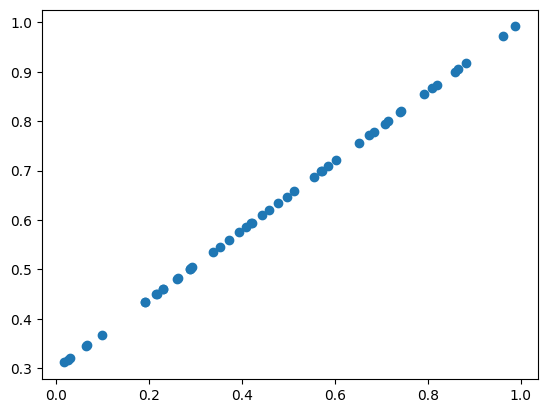

In [ ]:
X = torch.rand(50, 1)
weight = 0.7
bias = 0.3
y = weight * X + bias

# Plot the data
plt.scatter(X, y)
plt.show()


In [ ]:
# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

In [7]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

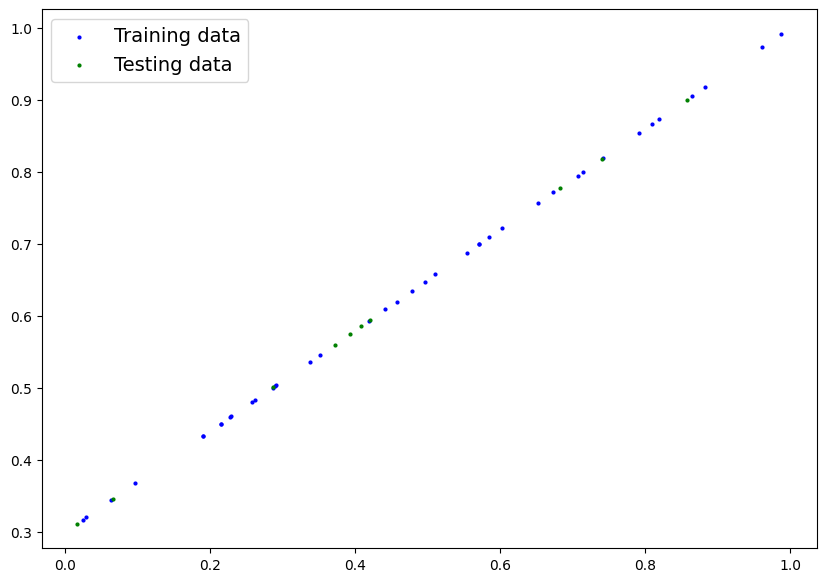

In [ ]:
plot_predictions()

In [ ]:
## Build model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize model parameters. This can be other layers from torch.nn, single parameters, hardcoded values or functions
    self.weights = nn.Parameter(torch.randn(1,
                                requires_grad=True, #<- Cant his parameter be updated via gradient descent
                                dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                requires_grad=True,
                                dtype=torch.float))

    # Any subclass of nn.Module needs to overwrite the forward() method
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x -> Input data
    return self.weights * x + self.bias

What our model does:
- Start with random values
- Look at training data and adjust the random values (weight, bias) to better represent (or get closer to) the ideal values (weight and bias used to create data)

How does it do so?

Through two main algorithms:
1. Gradient descent
1. Back-propagation

### PyTorch model building essentials

- `torch.nn` - Contains all of the buildings for computational graphs (a NN can be considered a computational graph)
- `torch.nn.Parameter` - What parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
- `torch.nn.Module` - The base class for all neural network modules, if you subclass it, you should overwrite forward()
- `torch.optim` - This where the optimizers live in PyTorch, they will help with gradient descent
- `def forward()` - All nn.Moduile subclasses require you to overwrite forward(). This method defines what happens in the forward computation

In [ ]:
# Checking contents of PyTorch model

torch.manual_seed(42)

# Create instance of the model
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check the model's predictive power, let's see how well it predicts `y_test` based on `x_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.2613],
        [0.3781],
        [0.1513],
        [0.2256],
        [0.4176],
        [0.2664],
        [0.2706],
        [0.3588],
        [0.2540],
        [0.1345]])

In [ ]:
y_test

tensor([[0.5755],
        [0.8184],
        [0.3467],
        [0.5012],
        [0.9004],
        [0.5860],
        [0.5947],
        [0.7782],
        [0.5604],
        [0.3117]])

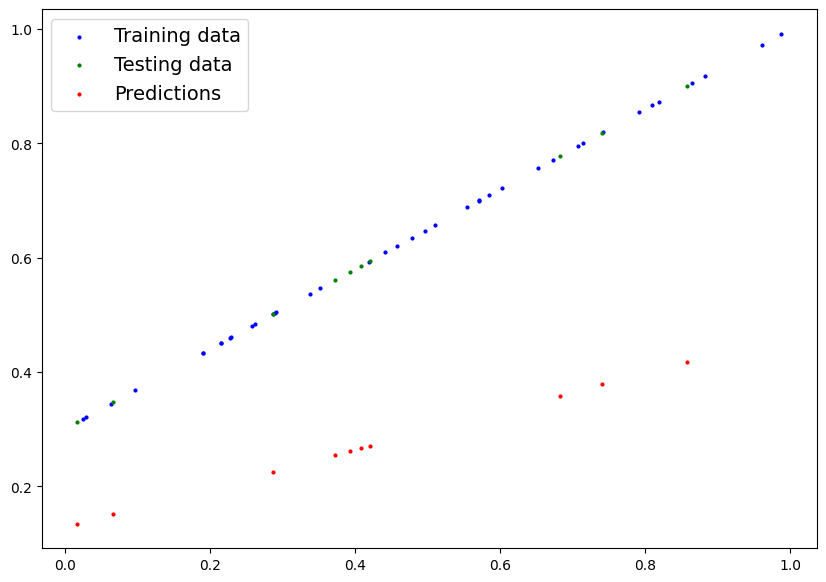

In [ ]:
plot_predictions(predictions=y_preds)

### Train model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters.

Or in other words, from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your model's predictions are is using a loss function.

* Note: Loss function may also be called cost function or criteron in different areas. For our case, we're going to refer to it as loss function.

This we need to train:

* **Loss Function:** A function to measure how wrong your model's predictions are to your ideal output. Lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters to improve the loss function.

Adn specifically for PyTorch, we need:
* A training loop
* A test loop

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an opitmizer (Stochastic Gradient Descent)
opt = torch.optim.SGD(params = model_0.parameters(),
                      lr = 0.01) # lr = learning rate, possibly the most important hyperparameter you can set

Which loss function and optimizer to use depends on the kind of problem to solve. For example, for image classification, a Binary Cross Entropy (BCE) loss functions is typically used.

### Building a training loop (and a testing loop) in PyTorch

A couple things we need in a training loop:
0. Loop through the data.
0. Forward pass (this involves data moving through our model's `forward()` method) to make predictions on data - also called forward propagation.
0. Calculate the loss (compare forward pass predictions to ground truth labels).
0. Optimizer zero grad.
0. Loss backward - move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss (**backpropagation**).
0. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**).

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data...
epochs = 1 # This is a hyperparameter

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f'Loss: {loss}')

  # 3. Optimizer zero grad
  opt.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  opt.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them abocve in step 3 fro the next iteration of the loop

  ### Testing
  model_0.eval() # turns off gradient tracking


Loss: 0.18659493327140808


In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.4177])), ('bias', tensor([0.2788]))])

In [ ]:
weight, bias

(0.7, 0.3)

In [ ]:
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
# Training loop
def train_model(model, X_train, y_train, epochs, loss_fn, opt_class=torch.optim.SGD, lr=0.01):
  opt = opt_class(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(f'Loss: {loss}')


In [ ]:
loss_fn = nn.L1Loss()
train_model(model_0, X_train, y_train, 100, loss_fn)

Loss: 0.3424481749534607
Loss: 0.3302261233329773
Loss: 0.31800416111946106
Loss: 0.30578210949897766
Loss: 0.29356008768081665
Loss: 0.281338095664978
Loss: 0.26911604404449463
Loss: 0.256894052028656
Loss: 0.2446720153093338
Loss: 0.2324499636888504
Loss: 0.22022798657417297
Loss: 0.20800594985485077
Loss: 0.19578392803668976
Loss: 0.18356190621852875
Loss: 0.17133989930152893
Loss: 0.1591179072856903
Loss: 0.1468958854675293
Loss: 0.1346738636493683
Loss: 0.12257514148950577
Loss: 0.11229412257671356
Loss: 0.10291154682636261
Loss: 0.09438994526863098
Loss: 0.08586834371089935
Loss: 0.07751058787107468
Loss: 0.07099169492721558
Loss: 0.06631027162075043
Loss: 0.06274305284023285
Loss: 0.060240488499403
Loss: 0.058541715145111084
Loss: 0.05684293061494827
Loss: 0.055268775671720505
Loss: 0.05401589348912239
Loss: 0.05293110013008118
Loss: 0.05184630677103996
Loss: 0.05076150968670845
Loss: 0.049676716327667236
Loss: 0.04862907528877258
Loss: 0.047787729650735855
Loss: 0.0469626970589

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6119])), ('bias', tensor([0.3438]))])

In [ ]:
def train_model(model, X_train, y_train, epochs, loss_fn, opt_class=torch.optim.SGD, lr=0.01, enable_test = True):
  opt = opt_class(model.parameters(), lr)

  # Track different values
  epoch_count = []
  loss_values = []
  test_loss_values = []

  for epoch in range(epochs):
    # Training loop
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if not enable_test:
      continue

    # Testing loop
    model.eval() # turns off settings not needed for evaluation/testing

    with torch.inference_mode(): # turns off gradient tracking & other things behind the scenes
      test_pred = model(X_test)

      # 1. Do the forward pass
      test_pred = model_0(X_test)

      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test)

      # Print out what is happening
      if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss)

        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
  return epoch_count, loss_values, test_loss_values

In [ ]:
loss_fn = nn.L1Loss()
epoch_count, loss_values, test_loss_values = train_model(model_0, X_train, y_train, 200, loss_fn)

Epoch: 0 | Loss: 0.3424481749534607 | Test loss: 0.3135063052177429
Epoch: 10 | Loss: 0.22022798657417297 | Test loss: 0.19348397850990295
Epoch: 20 | Loss: 0.10291154682636261 | Test loss: 0.08734976500272751
Epoch: 30 | Loss: 0.055268775671720505 | Test loss: 0.046527910977602005
Epoch: 40 | Loss: 0.04568126052618027 | Test loss: 0.043187301605939865
Epoch: 50 | Loss: 0.04102116823196411 | Test loss: 0.04093126207590103
Epoch: 60 | Loss: 0.03684214875102043 | Test loss: 0.03675258159637451
Epoch: 70 | Loss: 0.032663121819496155 | Test loss: 0.0325738899409771
Epoch: 80 | Loss: 0.028483008965849876 | Test loss: 0.028395185247063637
Epoch: 90 | Loss: 0.024299362674355507 | Test loss: 0.024024318903684616
Epoch: 100 | Loss: 0.02012033760547638 | Test loss: 0.019845640286803246
Epoch: 110 | Loss: 0.01594131626188755 | Test loss: 0.01566695049405098
Epoch: 120 | Loss: 0.011762285605072975 | Test loss: 0.011488249525427818
Epoch: 130 | Loss: 0.0075832633301615715 | Test loss: 0.00730955880

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.5681],
        [0.8077],
        [0.3424],
        [0.4948],
        [0.8886],
        [0.5785],
        [0.5871],
        [0.7681],
        [0.5532],
        [0.3079]])

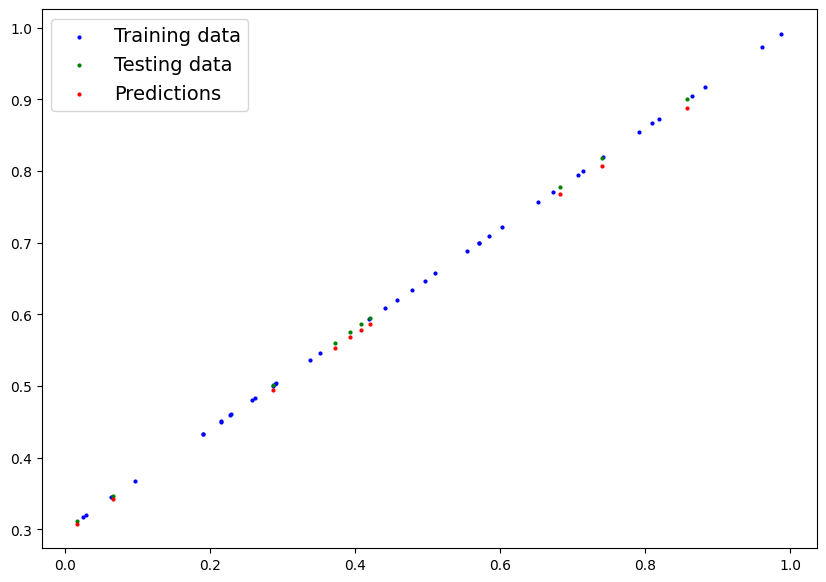

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6906])), ('bias', tensor([0.2963]))])

In [ ]:
len(epoch_count), len(loss_values), len(test_loss_values)

(20, 20, 20)

In [ ]:
epoch_count, loss_values, test_loss_values

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190],
 [array(0.34244817, dtype=float32),
  array(0.22022799, dtype=float32),
  array(0.10291155, dtype=float32),
  array(0.05526878, dtype=float32),
  array(0.04568126, dtype=float32),
  array(0.04102117, dtype=float32),
  array(0.03684215, dtype=float32),
  array(0.03266312, dtype=float32),
  array(0.02848301, dtype=float32),
  array(0.02429936, dtype=float32),
  array(0.02012034, dtype=float32),
  array(0.01594132, dtype=float32),
  array(0.01176229, dtype=float32),
  array(0.00758326, dtype=float32),
  array(0.0034048, dtype=float32),
  array(0.00813165, dtype=float32),
  array(0.00813165, dtype=float32),
  array(0.00813165, dtype=float32),
  array(0.00813165, dtype=float32),
  array(0.00813165, dtype=float32)],
 [tensor(0.3135),
  tensor(0.1935),
  tensor(0.0873),
  tensor(0.0465),
  tensor(0.0432),
  tensor(0.0409),
  tensor(0.0368),
  tensor(0.0326),
  tens

In [ ]:
# Plot the loss curves
def plot_loss_curves(epoch_count, loss_values, test_loss_values):
  plt.plot(epoch_count, loss_values, label='Train loss')
  plt.plot(epoch_count, test_loss_values, label='Test loss')
  plt.legend()

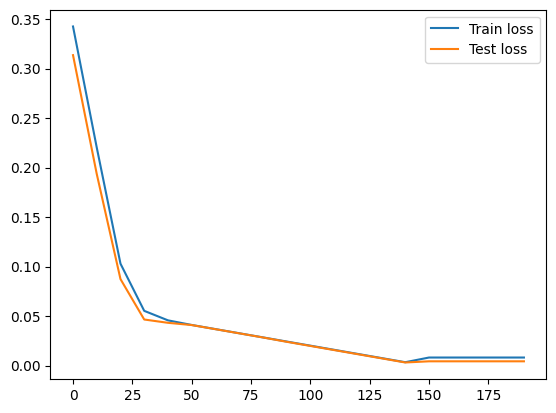

In [ ]:
plot_loss_curves(epoch_count, loss_values, test_loss_values)

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch

1. `torch.save()` allows you to save a PyTorch object in Python's pickle format
1. `torch.load()` allows you to load a saved PyTorch object
1. `torch.nn.Module.load_state_dict()` this allows to load a model's saved state dictionary

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 May 20 22:33 01_pytorch_workflow_model_0.pth


### Loading a PyTorch

Since we saved our model's `state_dict()` instead of the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that



In [ ]:
# To load in a saved state dict we have to instantiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will upadate the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6906])), ('bias', tensor([0.2963]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.5681],
        [0.8077],
        [0.3424],
        [0.4948],
        [0.8886],
        [0.5785],
        [0.5871],
        [0.7681],
        [0.5532],
        [0.3079]])

In [ ]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together


Let's go back through the steos above and see it all in one place

In [1]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

Create device-agnostic code

This means if we have access to a GPU, our coe will use it. If not, the code will default to CPU

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
!nvidia-smi

Tue May 21 19:57:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data

In [65]:
# Create some data using linear regression formula y = w * X + b

weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y tensors
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze errors will pop out
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [66]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

In [67]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

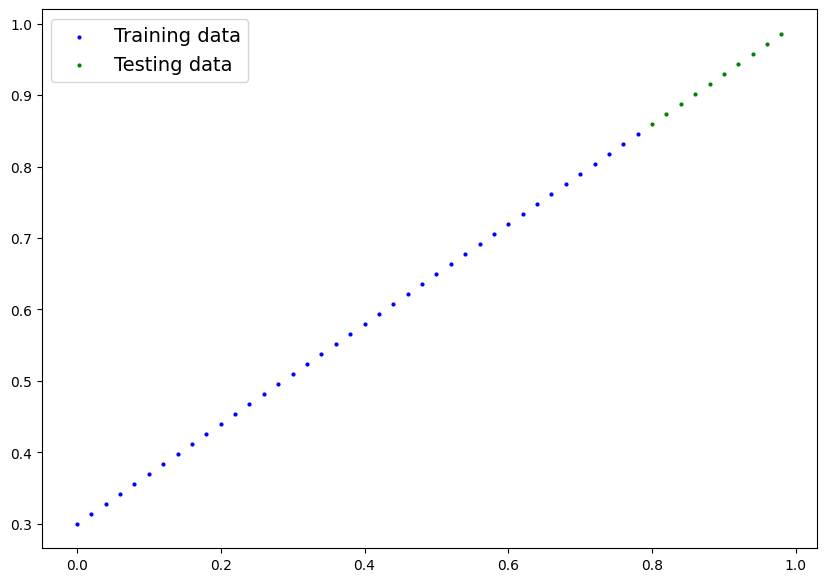

In [68]:
# Plot the data
plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None)

## Build PyTorch Linear model

In [69]:
## Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [70]:
# Set the model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## Training

For training we need
- Loss function
- Optimizer
- Training loop
- Testing loop

In [71]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
opt_class = torch.optim.SGD

In [72]:
# Set device for data
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [73]:
def train_model(model, X_train, y_train, X_test=None, y_test=None, epochs=100, loss_fn=nn.L1Loss(), opt_class=torch.optim.SGD, lr=0.01, enable_test = True):
  opt = opt_class(model.parameters(), lr)

  # Put data on target device (device agnostic code)
  X_train = X_train
  y_train = y_train


  # Track different values
  epoch_count = []
  loss_values = []
  test_loss_values = []

  for epoch in range(epochs):
    # Training loop
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if not enable_test:
      continue

    # Testing loop
    X_test = X_test
    y_test = y_test
    model.eval() # turns off settings not needed for evaluation/testing

    with torch.inference_mode(): # turns off gradient tracking & other things behind the scenes
      test_pred = model(X_test)

      # 1. Do the forward pass
      test_pred = model(X_test)

      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test)

      # Print out what is happening
      if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
  return epoch_count, loss_values, test_loss_values

In [74]:
epoch_count, loss_values, test_loss_values = train_model(model_1, X_train, y_train, X_test, y_test, 200, loss_fn, opt_class)

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [75]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

## Making and evaluating predictions

In [76]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions with model on test data
with torch.inference_mode():
  y_preds = model_1(X_test)

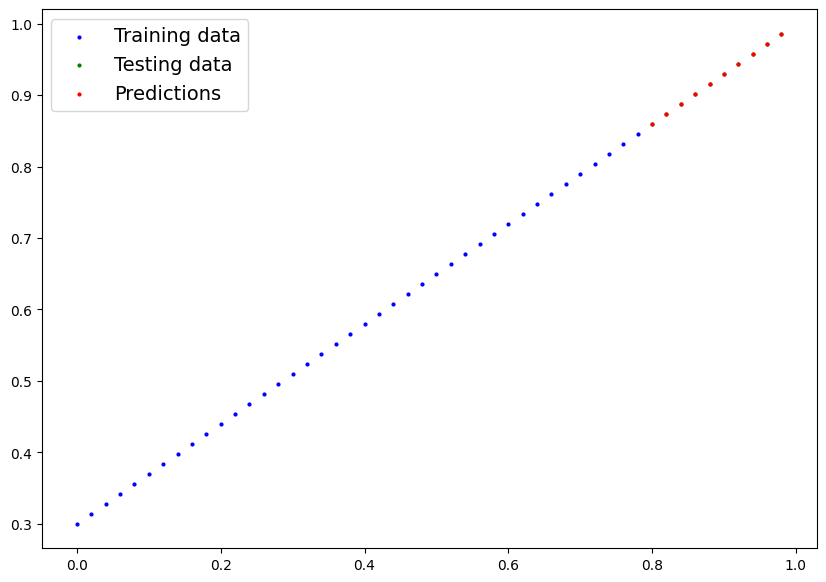

In [78]:
plot_predictions(predictions=y_preds.cpu())

## Saving & loading a trained model

In [83]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

In [84]:
# Load model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [85]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [87]:
loaded_model_1.to(device)
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

In [88]:
loaded_model_1_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')